In [34]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from brukeropusreader import read_file
from scipy.interpolate import interp1d
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.regularizers import l1, l2


In [35]:


# Define folder paths
folder_path_oe = 'Spectra RE'
folder_path_re = 'Spectra OE'
folder_path_trachea = 'Spectra TR'

# Function to list files in a folder
def list_files(folder_path):
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    return files

# List files in each folder
files_re = list_files(folder_path_re)
files_oe = list_files(folder_path_oe)
files_tr = list_files(folder_path_trachea)

# Displaying file names and their count
print("RE Folder:")
print(f"Number of files: {len(files_re)}")
print("Files:", files_re)





RE Folder:
Number of files: 210
Files: ['20240408 A5 OE.0004', '20240408 A5 OE.0003', '20240408 A2 OE.0001', '15012024 OE 4.0000', '15012024 OE 3.0012', '20240311 OE 1.0003', '19022024 OE 4.0004', '05022024 OE 1 mit max druck.0004', '20240415 B5 OE.0002', '20240415 B2 OE.0000', '20240311 OE 1.0004', '05022024 OE 1 mit max druck.0003', '20240318 OE A2.0000', '20240311 OE 5.0001', '19022024 OE 4.0003', '20240304 OE 3.0000', '15012024 OE 3.0013', '15012024 OE 4.0001', '15012024 OE 3.0014', '20240408 A5 OE.0002', '20240408 A2 OE.0000', '20240304 OE 3.0001', '20240311 OE 5.0000', '19022024 OE 4.0002', '20240318 OE A2.0001', '05022024 OE 1 mit max druck.0002', '20240415 B5 OE.0004', '20240311 OE 1.0002', '20240415 B5 OE.0003', '20240415 B2 OE.0001', '19022024 OE 1.0000', '19022024 OE 5.0002', '20240318 OE A3.0001', '05022024 OE 2 mit max druck.0002', '05022024 OE 5 mit max druck.0000', '20240408 A3 OE.0000', '20240408 A4 OE.0002', '20240304 OE 2.0001', '15012024 OE 1.0004', '15012024 OE 5.00

In [36]:

# Define the common set of wavenumbers
start_wavenumber = 5000  # Starting wavenumber
end_wavenumber = 400  # Ending wavenumber
resolution = 1  # Resolution in cm⁻¹

# Generate the common set of wavenumbers
common_wavenumbers = np.arange(start_wavenumber, end_wavenumber - resolution, -resolution)

# Verify the first and last values as well as the size of the set to ensure it matches expectations
print("First wavenumber:", common_wavenumbers[0])
print("Last wavenumber:", common_wavenumbers[-1])
print("Total number of points:", len(common_wavenumbers))

def get_wavenumbers(file_path):
    opus_data = read_file(file_path)
    num_points = len(opus_data['AB'])
    start_wn = opus_data['AB Data Parameter']['FXV']
    end_wn = opus_data['AB Data Parameter']['LXV']
    wavenumbers = np.linspace(start_wn, end_wn, num_points)
    return wavenumbers

def get_spectral_data(file_path):
    opus_data = read_file(file_path)
    spectral_data = opus_data['AB']
    return spectral_data

def interpolate_to_common_wavenumbers(file_path, common_wavenumbers):
    original_wavenumbers = get_wavenumbers(file_path)
    original_data = get_spectral_data(file_path)
    interpolation_func = interp1d(original_wavenumbers, original_data, kind='linear', fill_value="extrapolate")
    interpolated_data = interpolation_func(common_wavenumbers)
    return interpolated_data

def z_score_normalize(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    normalized_data = (data - mean) / std_dev
    return normalized_data

def process_directory(folder_path, common_wavenumbers):
    normalized_data_list = []
    files = list_files(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        data = interpolate_to_common_wavenumbers(file_path, common_wavenumbers)
        mask = (common_wavenumbers >= 900) & (common_wavenumbers <= 1800)
        data = data[mask]
        normalized_data = z_score_normalize(data)
        normalized_data_list.append(normalized_data)
    return np.array(normalized_data_list)

# Process directories
data_oe = process_directory(folder_path_oe, common_wavenumbers)
data_re = process_directory(folder_path_re, common_wavenumbers)
data_trachea = process_directory(folder_path_trachea, common_wavenumbers)




First wavenumber: 5000
Last wavenumber: 400
Total number of points: 4601


Epoch 1/100


/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3744 - loss: 8.6598 - val_accuracy: 0.5045 - val_loss: 8.3881
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5653 - loss: 7.3089 - val_accuracy: 0.2703 - val_loss: 14.4070
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5686 - loss: 5.3061 - val_accuracy: 0.2703 - val_loss: 6.8708
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6430 - loss: 4.0561 - val_accuracy: 0.3784 - val_loss: 5.4488
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6142 - loss: 3.4186 - val_accuracy: 0.3784 - val_loss: 4.2758
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7035 - loss: 2.6321 - val_accuracy: 0.2703 - val_loss: 4.6559
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6325 - loss: 2.3728 - val_accuracy: 0.5495 - val_loss: 2.3792
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6588 - loss: 2.1395 - val_accuracy: 0.3514 - val_loss: 2

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6334 - loss: 1.5755 - val_accuracy: 0.3784 - val_loss: 2.8237
Epoch 52/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7154 - loss: 1.2550 - val_accuracy: 0.3784 - val_loss: 2.4319
Epoch 53/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7205 - loss: 1.1632 - val_accuracy: 0.3784 - val_loss: 2.3985
Epoch 54/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6900 - loss: 1.2196 - val_accuracy: 0.3784 - val_loss: 2.9060
Epoch 55/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5988 - loss: 1.3724 - val_accuracy: 0.2703 - val_loss: 3.4460
Epoch 56/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6752 - loss: 1.6404 - val_accuracy: 0.6847 - val_loss: 1.6167
Epoch 57/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6331 - loss: 1.5735 - val_accuracy: 0.4054 - val_loss: 2.4661
Epoch 58/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6733 - loss: 1.4687 - val_accuracy: 0.7027 - val_lo

/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


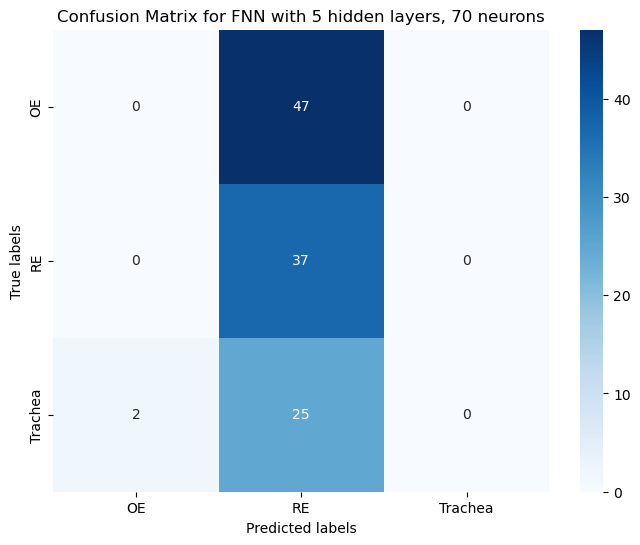

In [37]:
# Combine the average spectral data into one dataset and create labels
X = np.vstack([data_oe, data_re, data_trachea])
y = np.array([0] * len(data_oe) + [1] * len(data_re) + [2] * len(data_trachea))

# Split the data into a temporary training dataset and final test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary training dataset into actual training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Neural Network model training with Batch Normalization and Dropout
def create_model(input_neurons, num_hidden_layers, hidden_neurons, learning_rate=0.01, dropout_rate=0.5, l1_reg=0.01, l2_reg=0.01):
    model = Sequential()
    model.add(Dense(input_neurons, input_shape=(X_train.shape[1],),
                    kernel_initializer=RandomNormal(mean=0.0, stddev=1/np.sqrt(X_train.shape[1])),
                    activation='selu',
                    kernel_regularizer=l1(l1_reg)))  # Added L1 regularization
    model.add(BatchNormalization())

    for _ in range(num_hidden_layers):
        model.add(Dense(hidden_neurons,
                        kernel_initializer=RandomNormal(mean=0.0, stddev=1/np.sqrt(hidden_neurons)),
                        activation='selu',
                        kernel_regularizer=l2(l2_reg)))  # Added L2 regularization
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))  # Dropout after Batch Normalization

    model.add(Dense(3, kernel_initializer=RandomNormal(mean=0.0, stddev=1/np.sqrt(hidden_neurons)), activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Parameters for the neural network architecture
input_neurons = 17
hidden_layers = 5
hidden_neurons = 70

# Training configurations (You can adjust these)
learning_rate = 0.01
epochs = 100
dropout_rate = 0.42  # You can experiment with different dropout rates
l1_reg = 0.01  # L1 regularization factor
l2_reg = 0.01  # L2 regularization factor

# Create and train the model with the specified configuration
model = create_model(input_neurons=input_neurons, num_hidden_layers=hidden_layers,
                     hidden_neurons=hidden_neurons, learning_rate=learning_rate, dropout_rate=dropout_rate,
                     l1_reg=l1_reg, l2_reg=l2_reg)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=32,
                    validation_data=(X_val, y_val), verbose=1)

# Evaluate the model
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(f"\nEvaluation for FNN with {hidden_layers} hidden layers, {hidden_neurons} neurons:")
print(classification_report(y_test, y_pred, target_names=['OE', 'RE', 'Trachea']))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['OE', 'RE', 'Trachea'], yticklabels=['OE', 'RE', 'Trachea'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix for FNN with {hidden_layers} hidden layers, {hidden_neurons} neurons')
plt.show()

In [38]:
pip install keras-tuner


Note: you may need to restart the kernel to use updated packages.


Reloading Tuner from my_dir/bayesian_opt/tuner0.json


/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best hyperparameters:
{'input_neurons': 50, 'l1_reg': 0.0006535704223306199, 'num_hidden_layers': 1, 'hidden_neurons_0': 60, 'l2_reg': 0.006325081881197132, 'dropout_rate': 0.45, 'learning_rate': 0.00017509163221934835, 'hidden_neurons_1': 60, 'hidden_neurons_2': 30, 'hidden_neurons_3': 60, 'hidden_neurons_4': 40}
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9559 - loss: 1.1251  
Test accuracy: 0.954954981803894
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
              precision    recall  f1-score   support

          OE       0.98      0.91      0.95        47
          RE       0.92      0.97      0.95        37
     Trachea       0.96      1.00      0.98        27

    accuracy                           0.95       111
   macro avg       0.95      0.96      0.96       111
weighted avg       0.96      0.95      0.95       111



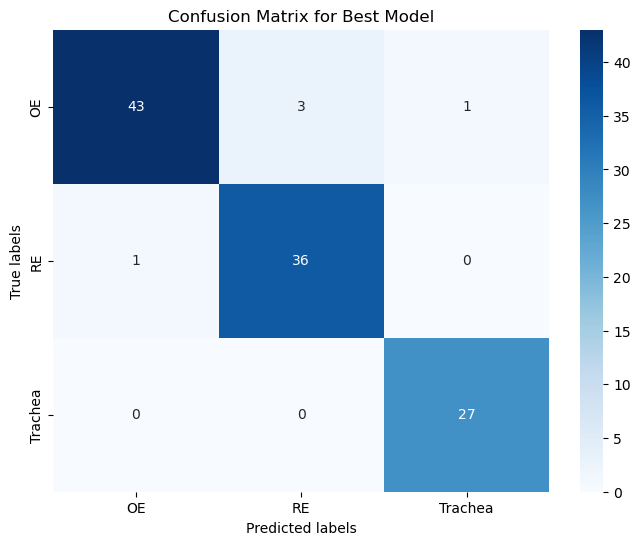

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from keras_tuner import BayesianOptimization

# Define the model creation function with hyperparameters to be tuned
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('input_neurons', min_value=10, max_value=100, step=10),
        input_shape=(X_train.shape[1],),
        kernel_initializer=RandomNormal(mean=0.0, stddev=1/np.sqrt(X_train.shape[1])),
        activation='selu',
        kernel_regularizer=tf.keras.regularizers.l1(hp.Float('l1_reg', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    ))
    model.add(BatchNormalization())

    for i in range(hp.Int('num_hidden_layers', 4, 8)):
        model.add(Dense(
            units=hp.Int(f'hidden_neurons_{i}', min_value=20, max_value=100, step=10),
            kernel_initializer=RandomNormal(mean=0.0, stddev=1/np.sqrt(hp.Int(f'hidden_neurons_{i}', min_value=20, max_value=100, step=10))),
            activation='selu',
            kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='LOG'))
        ))
        model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.05)))

    model.add(Dense(3, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize the tuner with Bayesian Optimization
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=1,
    directory='my_dir',
    project_name='bayesian_opt'
)

# Run the search for the best hyperparameters
tuner.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val), verbose=1)

# Retrieve the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print out the best hyperparameters
print("Best hyperparameters:")
print(best_hyperparameters.values)

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

# Predict and evaluate the model performance
y_pred = np.argmax(best_model.predict(X_test), axis=-1)
print(classification_report(y_test, y_pred, target_names=['OE', 'RE', 'Trachea']))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['OE', 'RE', 'Trachea'], yticklabels=['OE', 'RE', 'Trachea'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Best Model')
plt.show()


Trial 30 Complete [00h 00m 20s]
val_accuracy: 0.7027027010917664

Best val_accuracy So Far: 0.9099099040031433
Total elapsed time: 00h 08m 38s


/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best hyperparameters:
{'input_neurons': 30, 'l1_reg': 3.026813046853553e-05, 'hidden_neurons_0': 70, 'l2_reg': 6.266052890779786e-05, 'dropout_rate': 0.45, 'hidden_neurons_1': 100, 'hidden_neurons_2': 100, 'hidden_neurons_3': 80, 'hidden_neurons_4': 70, 'learning_rate': 0.000301253516865534}
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9166 - loss: 0.2580  
Test accuracy: 0.9009009003639221
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
              precision    recall  f1-score   support

          OE       0.86      0.91      0.89        47
          RE       0.88      0.81      0.85        37
     Trachea       1.00      1.00      1.00        27

    accuracy                           0.90       111
   macro avg       0.91      0.91      0.91       111
weighted avg       0.90      0.90      0.90       111



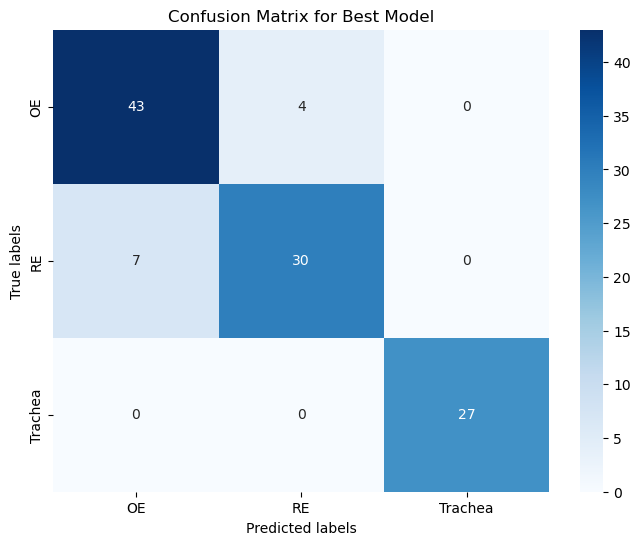

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from keras_tuner import BayesianOptimization
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the model creation function with hyperparameters to be tuned
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('input_neurons', min_value=10, max_value=100, step=10),
        input_shape=(X_train.shape[1],),
        kernel_initializer=RandomNormal(mean=0.0, stddev=1/np.sqrt(X_train.shape[1])),
        activation='selu',
        kernel_regularizer=tf.keras.regularizers.l1(hp.Float('l1_reg', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    ))
    model.add(BatchNormalization())

    for i in range(5):  # Fixed number of hidden layers to 5
        model.add(Dense(
            units=hp.Int(f'hidden_neurons_{i}', min_value=20, max_value=100, step=10),
            kernel_initializer=RandomNormal(mean=0.0, stddev=1/np.sqrt(hp.Int(f'hidden_neurons_{i}', min_value=20, max_value=100, step=10))),
            activation='selu',
            kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='LOG'))
        ))
        model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.05)))

    model.add(Dense(3, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize the tuner with Bayesian Optimization
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=1,
    directory='my_dir',
    project_name='bayesian_opt_fixed_hidden_layers'
)

# Run the search for the best hyperparameters
tuner.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val), verbose=1)

# Retrieve the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print out the best hyperparameters
print("Best hyperparameters:")
print(best_hyperparameters.values)

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

# Predict and evaluate the model performance
y_pred = np.argmax(best_model.predict(X_test), axis=-1)
print(classification_report(y_test, y_pred, target_names=['OE', 'RE', 'Trachea']))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['OE', 'RE', 'Trachea'], yticklabels=['OE', 'RE', 'Trachea'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Best Model')
plt.show()


/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.3975 - loss: 1.6184 - val_accuracy: 0.3964 - val_loss: 1.3638
Epoch 2/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4181 - loss: 1.7192 - val_accuracy: 0.5135 - val_loss: 1.2962
Epoch 3/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3981 - loss: 1.6016 - val_accuracy: 0.5315 - val_loss: 1.2518
Epoch 4/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4563 - loss: 1.5511 - val_accuracy: 0.5045 - val_loss: 1.2480
Epoch 5/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4758 - loss: 1.2721 - val_accuracy: 0.5405 - val_loss: 1.2058
Epoch 6/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4936 - loss: 1.3699 - val_accuracy: 0.4595 - val_loss: 1.1542
Epoch 7/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4855 - loss: 1.3545 - val_accuracy: 0.5135 - val_loss: 1.0364
Epoch 8/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5412 - loss: 1.2727 - val_accuracy:

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7444 - loss: 0.6143 - val_accuracy: 0.7928 - val_loss: 0.6072
Epoch 52/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8004 - loss: 0.5705 - val_accuracy: 0.7928 - val_loss: 0.6549
Epoch 53/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7418 - loss: 0.6588 - val_accuracy: 0.6847 - val_loss: 0.7398
Epoch 54/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7409 - loss: 0.6759 - val_accuracy: 0.6937 - val_loss: 0.9319
Epoch 55/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7845 - loss: 0.5493 - val_accuracy: 0.5676 - val_loss: 1.0188
Epoch 56/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7553 - loss: 0.6231 - val_accuracy: 0.3514 - val_loss: 2.6781
Epoch 57/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8101 - loss: 0.6356 - val_accuracy: 0.3514 - val_loss: 2.5754
Epoch 58/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8024 - loss: 0.5135 - val_accuracy: 0.396

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8299 - loss: 0.4752 - val_accuracy: 0.6216 - val_loss: 3.1213
Epoch 102/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8383 - loss: 0.3977 - val_accuracy: 0.6216 - val_loss: 3.0299
Epoch 103/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8926 - loss: 0.3430 - val_accuracy: 0.6216 - val_loss: 3.0826
Epoch 104/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9113 - loss: 0.3138 - val_accuracy: 0.6216 - val_loss: 2.8843
Epoch 105/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8852 - loss: 0.3633 - val_accuracy: 0.5946 - val_loss: 2.7715
Epoch 106/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8980 - loss: 0.3276 - val_accuracy: 0.5856 - val_loss: 2.0951
Epoch 107/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9019 - loss: 0.3163 - val_accuracy: 0.6847 - val_loss: 1.5822
Epoch 108/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9022 - loss: 0.3352 - val_accuracy: 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9153 - loss: 0.3357 - val_accuracy: 0.7568 - val_loss: 0.7178
Epoch 152/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9513 - loss: 0.1996 - val_accuracy: 0.7477 - val_loss: 0.8208
Epoch 153/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9535 - loss: 0.1745 - val_accuracy: 0.6667 - val_loss: 1.0326
Epoch 154/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9375 - loss: 0.2268 - val_accuracy: 0.7387 - val_loss: 0.6885
Epoch 155/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9033 - loss: 0.3360 - val_accuracy: 0.3964 - val_loss: 3.9892
Epoch 156/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9126 - loss: 0.2764 - val_accuracy: 0.3964 - val_loss: 3.8955
Epoch 157/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9144 - loss: 0.3228 - val_accuracy: 0.5315 - val_loss: 3.1108
Epoch 158/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8727 - loss: 0.4193 - val_accura

Epoch 201/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9274 - loss: 0.2101 - val_accuracy: 0.4054 - val_loss: 3.1575
Epoch 202/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9610 - loss: 0.1586 - val_accuracy: 0.4414 - val_loss: 2.8795
Epoch 203/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9430 - loss: 0.1798 - val_accuracy: 0.4955 - val_loss: 2.6879
Epoch 204/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9672 - loss: 0.1388 - val_accuracy: 0.6667 - val_loss: 1.5160
Epoch 205/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9782 - loss: 0.1191 - val_accuracy: 0.7027 - val_loss: 1.0753
Epoch 206/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9423 - loss: 0.2040 - val_accuracy: 0.4324 - val_loss: 2.8248
Epoch 207/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9182 - loss: 0.2792 - val_accuracy: 0.4054 - val_loss: 2.7402
Epoch 208/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9485 - loss: 0.2006 

Epoch 251/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9721 - loss: 0.1487 - val_accuracy: 0.5676 - val_loss: 2.2774
Epoch 252/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9533 - loss: 0.1553 - val_accuracy: 0.6667 - val_loss: 1.4678
Epoch 253/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9783 - loss: 0.1132 - val_accuracy: 0.6577 - val_loss: 1.7603
Epoch 254/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9611 - loss: 0.1490 - val_accuracy: 0.5495 - val_loss: 3.0556
Epoch 255/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9625 - loss: 0.1338 - val_accuracy: 0.5135 - val_loss: 3.0847
Epoch 256/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9659 - loss: 0.1629 - val_accuracy: 0.6486 - val_loss: 1.5644
Epoch 257/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9917 - loss: 0.1037 - val_accuracy: 0.7027 - val_loss: 1.0545
Epoch 258/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9643 - loss: 0.1359 - 

Epoch 301/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9033 - loss: 0.4892 - val_accuracy: 0.8018 - val_loss: 0.8063
Epoch 302/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9709 - loss: 0.1465 - val_accuracy: 0.6667 - val_loss: 1.8806
Epoch 303/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9675 - loss: 0.1629 - val_accuracy: 0.8018 - val_loss: 0.6233
Epoch 304/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9437 - loss: 0.1791 - val_accuracy: 0.6126 - val_loss: 1.9989
Epoch 305/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9729 - loss: 0.1414 - val_accuracy: 0.7117 - val_loss: 1.2260
Epoch 306/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9825 - loss: 0.1057 - val_accuracy: 0.6937 - val_loss: 1.1221
Epoch 307/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9720 - loss: 0.1316 - val_accuracy: 0.6396 - val_loss: 1.5577
Epoch 308/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9480 - loss: 0

Epoch 351/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9497 - loss: 0.1792 - val_accuracy: 0.7928 - val_loss: 0.8249
Epoch 352/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9642 - loss: 0.1513 - val_accuracy: 0.6306 - val_loss: 1.8624
Epoch 353/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9733 - loss: 0.1415 - val_accuracy: 0.5676 - val_loss: 2.1066
Epoch 354/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9461 - loss: 0.1956 - val_accuracy: 0.8198 - val_loss: 0.9098
Epoch 355/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9863 - loss: 0.1091 - val_accuracy: 0.7658 - val_loss: 1.5083
Epoch 356/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9475 - loss: 0.2049 - val_accuracy: 0.8649 - val_loss: 0.5137
Epoch 357/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9653 - loss: 0.1411 - val_accuracy: 0.8288 - val_loss: 0.7667
Epoch 358/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9804 - loss: 0.1322 -

Epoch 401/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9656 - loss: 0.1732 - val_accuracy: 0.8378 - val_loss: 0.6229
Epoch 402/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9623 - loss: 0.1684 - val_accuracy: 0.7568 - val_loss: 0.9711
Epoch 403/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9765 - loss: 0.1191 - val_accuracy: 0.6306 - val_loss: 2.5933
Epoch 404/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9743 - loss: 0.1369 - val_accuracy: 0.7477 - val_loss: 1.3623
Epoch 405/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9773 - loss: 0.1046 - val_accuracy: 0.7928 - val_loss: 1.0709
Epoch 406/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9635 - loss: 0.1455 - val_accuracy: 0.8198 - val_loss: 0.6268
Epoch 407/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9866 - loss: 0.0963 - val_accuracy: 0.8649 - val_loss: 0.4922
Epoch 408/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9862 - loss: 0.0950 - 

Epoch 451/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9733 - loss: 0.1329 - val_accuracy: 0.8739 - val_loss: 0.5617
Epoch 452/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9687 - loss: 0.1535 - val_accuracy: 0.8198 - val_loss: 0.8067
Epoch 453/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9680 - loss: 0.1585 - val_accuracy: 0.7838 - val_loss: 1.1160
Epoch 454/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9968 - loss: 0.0751 - val_accuracy: 0.8649 - val_loss: 0.3513
Epoch 455/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9836 - loss: 0.1004 - val_accuracy: 0.5225 - val_loss: 3.5748
Epoch 456/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9671 - loss: 0.1108 - val_accuracy: 0.6847 - val_loss: 1.3795
Epoch 457/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9669 - loss: 0.1063 - val_accuracy: 0.5946 - val_loss: 2.4231
Epoch 458/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9668 - loss: 0.1

Epoch 501/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9547 - loss: 0.1514 - val_accuracy: 0.6396 - val_loss: 3.4889
Epoch 502/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9955 - loss: 0.0764 - val_accuracy: 0.6577 - val_loss: 2.7774
Epoch 503/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9800 - loss: 0.0941 - val_accuracy: 0.7117 - val_loss: 1.3867
Epoch 504/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9698 - loss: 0.1341 - val_accuracy: 0.7838 - val_loss: 0.8106
Epoch 505/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9446 - loss: 0.2018 - val_accuracy: 0.5766 - val_loss: 3.2666
Epoch 506/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9380 - loss: 0.2106 - val_accuracy: 0.4955 - val_loss: 3.0061
Epoch 507/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9674 - loss: 0.1478 - val_accuracy: 0.6306 - val_loss: 1.7476
Epoch 508/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9755 - loss: 0.1088 - 

Epoch 551/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9699 - loss: 0.1346 - val_accuracy: 0.6396 - val_loss: 2.0442
Epoch 552/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9809 - loss: 0.1197 - val_accuracy: 0.6036 - val_loss: 2.1707
Epoch 553/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9391 - loss: 0.2115 - val_accuracy: 0.7297 - val_loss: 1.2599
Epoch 554/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9771 - loss: 0.0919 - val_accuracy: 0.7207 - val_loss: 2.0911
Epoch 555/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9521 - loss: 0.1786 - val_accuracy: 0.5766 - val_loss: 3.8936
Epoch 556/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9744 - loss: 0.1068 - val_accuracy: 0.4865 - val_loss: 4.5570
Epoch 557/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9664 - loss: 0.1417 - val_accuracy: 0.6216 - val_loss: 3.0788
Epoch 558/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9659 - loss: 0.1642 - 

Epoch 601/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9672 - loss: 0.1659 - val_accuracy: 0.6486 - val_loss: 2.3585
Epoch 602/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9846 - loss: 0.0892 - val_accuracy: 0.2883 - val_loss: 6.0860
Epoch 603/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9815 - loss: 0.0897 - val_accuracy: 0.2703 - val_loss: 9.9172
Epoch 604/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9665 - loss: 0.1609 - val_accuracy: 0.2703 - val_loss: 11.5990
Epoch 605/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9531 - loss: 0.1990 - val_accuracy: 0.2703 - val_loss: 10.4688
Epoch 606/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9894 - loss: 0.0817 - val_accuracy: 0.2703 - val_loss: 9.3037
Epoch 607/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9509 - loss: 0.1619 - val_accuracy: 0.2973 - val_loss: 7.8995
Epoch 608/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9619 - loss: 0.1202

Epoch 651/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9964 - loss: 0.0626 - val_accuracy: 0.3694 - val_loss: 5.3036
Epoch 652/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9917 - loss: 0.0842 - val_accuracy: 0.5946 - val_loss: 2.7876
Epoch 653/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9685 - loss: 0.1588 - val_accuracy: 0.7658 - val_loss: 1.5983
Epoch 654/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9971 - loss: 0.0673 - val_accuracy: 0.7748 - val_loss: 1.5330
Epoch 655/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9678 - loss: 0.1474 - val_accuracy: 0.5586 - val_loss: 4.0796
Epoch 656/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9928 - loss: 0.0868 - val_accuracy: 0.5135 - val_loss: 4.5584
Epoch 657/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0571 - val_accuracy: 0.5135 - val_loss: 4.3162
Epoch 658/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9802 - loss: 0.0947 - 

Epoch 701/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9609 - loss: 0.1948 - val_accuracy: 0.6126 - val_loss: 2.5599
Epoch 702/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9761 - loss: 0.1244 - val_accuracy: 0.4595 - val_loss: 4.6646
Epoch 703/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9524 - loss: 0.1579 - val_accuracy: 0.3694 - val_loss: 5.6444
Epoch 704/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9801 - loss: 0.0912 - val_accuracy: 0.5045 - val_loss: 3.5625
Epoch 705/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9845 - loss: 0.1306 - val_accuracy: 0.6847 - val_loss: 1.5521
Epoch 706/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9717 - loss: 0.1444 - val_accuracy: 0.6486 - val_loss: 2.1303
Epoch 707/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9896 - loss: 0.0779 - val_accuracy: 0.7568 - val_loss: 0.9027
Epoch 708/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9830 - loss: 0.1166 - 

Epoch 751/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9859 - loss: 0.1300 - val_accuracy: 0.7928 - val_loss: 0.7290
Epoch 752/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9783 - loss: 0.0983 - val_accuracy: 0.7838 - val_loss: 0.8270
Epoch 753/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9944 - loss: 0.0657 - val_accuracy: 0.8559 - val_loss: 0.5172
Epoch 754/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0519 - val_accuracy: 0.7838 - val_loss: 0.9907
Epoch 755/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9956 - loss: 0.0627 - val_accuracy: 0.7387 - val_loss: 1.1320
Epoch 756/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9960 - loss: 0.0621 - val_accuracy: 0.8108 - val_loss: 0.9624
Epoch 757/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9863 - loss: 0.0915 - val_accuracy: 0.6306 - val_loss: 2.9015
Epoch 758/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9911 - loss: 0.0774 -

Epoch 801/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9978 - loss: 0.0641 - val_accuracy: 0.7117 - val_loss: 1.2648
Epoch 802/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0575 - val_accuracy: 0.7748 - val_loss: 0.8919
Epoch 803/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9825 - loss: 0.0955 - val_accuracy: 0.7748 - val_loss: 0.7901
Epoch 804/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9618 - loss: 0.1451 - val_accuracy: 0.7207 - val_loss: 1.4150
Epoch 805/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9811 - loss: 0.0912 - val_accuracy: 0.7658 - val_loss: 1.7507
Epoch 806/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9889 - loss: 0.0781 - val_accuracy: 0.8288 - val_loss: 0.5656
Epoch 807/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9588 - loss: 0.1475 - val_accuracy: 0.6667 - val_loss: 2.1464
Epoch 808/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9725 - loss: 0.1137 

Epoch 851/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0536 - val_accuracy: 0.5586 - val_loss: 2.6780
Epoch 852/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9908 - loss: 0.0966 - val_accuracy: 0.5225 - val_loss: 3.0571
Epoch 853/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9856 - loss: 0.0779 - val_accuracy: 0.5676 - val_loss: 2.8183
Epoch 854/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9802 - loss: 0.0832 - val_accuracy: 0.5856 - val_loss: 2.9154
Epoch 855/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9941 - loss: 0.0633 - val_accuracy: 0.7117 - val_loss: 1.4197
Epoch 856/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9821 - loss: 0.0764 - val_accuracy: 0.8108 - val_loss: 0.6632
Epoch 857/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9986 - loss: 0.0563 - val_accuracy: 0.8468 - val_loss: 0.5607
Epoch 858/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9956 - loss: 0.05

Epoch 901/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9955 - loss: 0.0591 - val_accuracy: 0.5856 - val_loss: 3.9496
Epoch 902/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9853 - loss: 0.0951 - val_accuracy: 0.5946 - val_loss: 3.6517
Epoch 903/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9849 - loss: 0.0907 - val_accuracy: 0.5856 - val_loss: 3.7517
Epoch 904/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9849 - loss: 0.0702 - val_accuracy: 0.5676 - val_loss: 4.0511
Epoch 905/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9791 - loss: 0.1083 - val_accuracy: 0.6306 - val_loss: 3.2178
Epoch 906/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9922 - loss: 0.0725 - val_accuracy: 0.7748 - val_loss: 1.5859
Epoch 907/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9799 - loss: 0.0927 - val_accuracy: 0.6396 - val_loss: 2.4446
Epoch 908/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9961 - loss: 0.0542 - 

Epoch 951/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9735 - loss: 0.0857 - val_accuracy: 0.6216 - val_loss: 2.2554
Epoch 952/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9846 - loss: 0.0734 - val_accuracy: 0.5405 - val_loss: 3.6210
Epoch 953/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9914 - loss: 0.0613 - val_accuracy: 0.6216 - val_loss: 2.9297
Epoch 954/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9936 - loss: 0.0784 - val_accuracy: 0.5856 - val_loss: 2.8813
Epoch 955/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9861 - loss: 0.0738 - val_accuracy: 0.6036 - val_loss: 2.7409
Epoch 956/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9906 - loss: 0.0626 - val_accuracy: 0.5946 - val_loss: 2.6824
Epoch 957/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9732 - loss: 0.1063 - val_accuracy: 0.6577 - val_loss: 2.2697
Epoch 958/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9793 - loss: 0.078

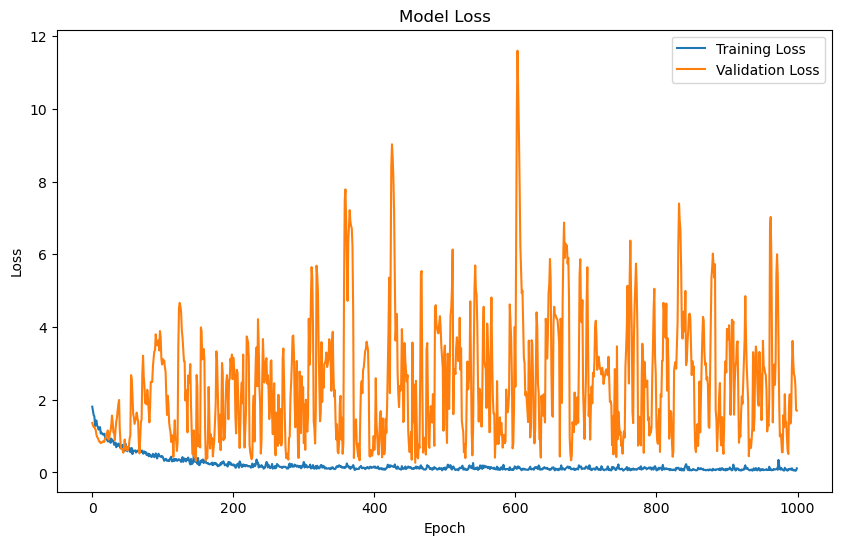

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7264 - loss: 1.6029 
Test accuracy: 0.6936936974525452
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
              precision    recall  f1-score   support

          OE       0.93      0.30      0.45        47
          RE       0.55      0.97      0.71        37
     Trachea       0.87      1.00      0.93        27

    accuracy                           0.69       111
   macro avg       0.79      0.76      0.70       111
weighted avg       0.79      0.69      0.65       111



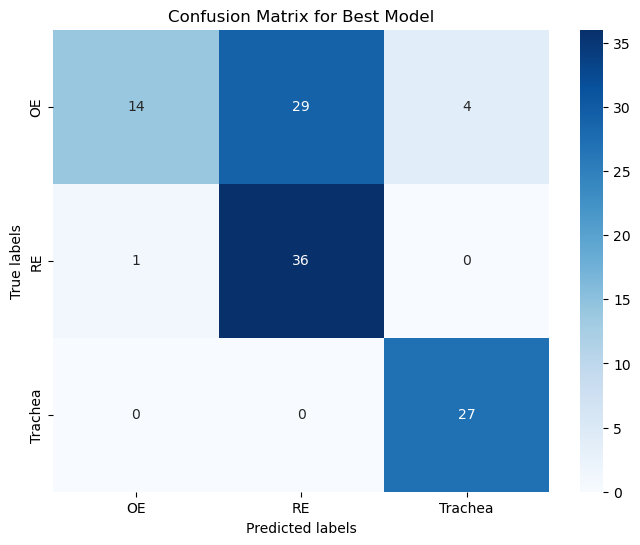

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set the best hyperparameters
best_hyperparameters = {
    'input_neurons': 30,
    'l1_reg': 3.026813046853553e-05,
    'hidden_neurons_0': 70,
    'l2_reg': 6.266052890779786e-05,
    'dropout_rate': 0.45,
    'hidden_neurons_1': 100,
    'hidden_neurons_2': 100,
    'hidden_neurons_3': 80,
    'hidden_neurons_4': 70,
    'learning_rate': 0.000301253516865534
}

# Build the model using the best hyperparameters
def build_fixed_model():
    model = Sequential()
    model.add(Dense(
        units=best_hyperparameters['input_neurons'],
        input_shape=(X_train.shape[1],),
        kernel_initializer=RandomNormal(mean=0.0, stddev=1/np.sqrt(X_train.shape[1])),
        activation='selu',
        kernel_regularizer=tf.keras.regularizers.l1(best_hyperparameters['l1_reg'])
    ))
    model.add(BatchNormalization())

    for i in range(5):  # Fixed number of hidden layers to 5
        model.add(Dense(
            units=best_hyperparameters[f'hidden_neurons_{i}'],
            kernel_initializer=RandomNormal(mean=0.0, stddev=1/np.sqrt(best_hyperparameters[f'hidden_neurons_{i}'])),
            activation='selu',
            kernel_regularizer=tf.keras.regularizers.l2(best_hyperparameters['l2_reg'])
        ))
        model.add(BatchNormalization())
        model.add(Dropout(rate=best_hyperparameters['dropout_rate']))

    model.add(Dense(3, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=best_hyperparameters['learning_rate']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Build and train the model
fixed_model = build_fixed_model()
history = fixed_model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), verbose=1)

# Save the model
fixed_model.save('best_model.h5')

# Save the loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Evaluate the best model on the test set
test_loss, test_accuracy = fixed_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

# Predict and evaluate the model performance
y_pred = np.argmax(fixed_model.predict(X_test), axis=-1)
print(classification_report(y_test, y_pred, target_names=['OE', 'RE', 'Trachea']))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['OE', 'RE', 'Trachea'], yticklabels=['OE', 'RE', 'Trachea'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Best Model')
plt.show()


In [43]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


Epoch 1/1000


/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3927 - loss: 1.7441 - val_accuracy: 0.2771 - val_loss: 2.6753
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4052 - loss: 1.6099 - val_accuracy: 0.2771 - val_loss: 2.4752
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4163 - loss: 1.4598 - val_accuracy: 0.2771 - val_loss: 2.2079
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4991 - loss: 1.3330 - val_accuracy: 0.2771 - val_loss: 2.2415
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5402 - loss: 1.2372 - val_accuracy: 0.2771 - val_loss: 2.3563
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4893 - loss: 1.3620 - val_accuracy: 0.3012 - val_loss: 2.0209
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5318 - loss: 1.2045 - val_accuracy: 0.3133 - val_loss: 1.6955
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5099 - loss: 1.3020 - val_accuracy: 0.3494 - val_l

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7102 - loss: 0.7190 - val_accuracy: 0.7711 - val_loss: 0.6021
Epoch 52/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6633 - loss: 0.7849 - val_accuracy: 0.8434 - val_loss: 0.6142
Epoch 53/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7312 - loss: 0.7506 - val_accuracy: 0.8554 - val_loss: 0.5129
Epoch 54/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6871 - loss: 0.7739 - val_accuracy: 0.8072 - val_loss: 0.5438
Epoch 55/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6954 - loss: 0.7511 - val_accuracy: 0.6747 - val_loss: 1.1157
Epoch 56/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6523 - loss: 0.8350 - val_accuracy: 0.6747 - val_loss: 1.0547
Epoch 57/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6937 - loss: 0.7247 - val_accuracy: 0.6747 - val_loss: 0.8753
Epoch 58/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7118 - loss: 0.6993 - val_accuracy: 0.

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7537 - loss: 0.6042 - val_accuracy: 0.7711 - val_loss: 0.4498
Epoch 102/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7914 - loss: 0.5176 - val_accuracy: 0.7831 - val_loss: 0.4182
Epoch 103/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7684 - loss: 0.5808 - val_accuracy: 0.7108 - val_loss: 0.7245
Epoch 104/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7339 - loss: 0.6071 - val_accuracy: 0.6988 - val_loss: 0.8554
Epoch 105/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7924 - loss: 0.5684 - val_accuracy: 0.7108 - val_loss: 0.8143
Epoch 106/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7967 - loss: 0.5343 - val_accuracy: 0.7108 - val_loss: 0.8314
Epoch 107/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7849 - loss: 0.5378 - val_accuracy: 0.7470 - val_loss: 0.6797
Epoch 108/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8437 - loss: 0.4752 - val_accuracy: 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8606 - loss: 0.4596 - val_accuracy: 0.7349 - val_loss: 0.7586
Epoch 152/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8225 - loss: 0.4734 - val_accuracy: 0.8193 - val_loss: 0.5308
Epoch 153/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8005 - loss: 0.5080 - val_accuracy: 0.8795 - val_loss: 0.3776
Epoch 154/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8416 - loss: 0.4182 - val_accuracy: 0.7470 - val_loss: 0.7178
Epoch 155/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8248 - loss: 0.4593 - val_accuracy: 0.7711 - val_loss: 0.6863
Epoch 156/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8578 - loss: 0.4143 - val_accuracy: 0.7229 - val_loss: 0.8138
Epoch 157/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7830 - loss: 0.5587 - val_accuracy: 0.8795 - val_loss: 0.4220
Epoch 158/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7992 - loss: 0.5338 - val_accuracy:

Epoch 201/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8848 - loss: 0.3284 - val_accuracy: 0.7590 - val_loss: 0.6652
Epoch 202/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8650 - loss: 0.4415 - val_accuracy: 0.8193 - val_loss: 0.4636
Epoch 203/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8844 - loss: 0.3680 - val_accuracy: 0.8795 - val_loss: 0.4094
Epoch 204/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8666 - loss: 0.4051 - val_accuracy: 0.7229 - val_loss: 0.8367
Epoch 205/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8722 - loss: 0.4012 - val_accuracy: 0.6867 - val_loss: 0.9246
Epoch 206/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8214 - loss: 0.4469 - val_accuracy: 0.7831 - val_loss: 0.5627
Epoch 207/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8566 - loss: 0.3914 - val_accuracy: 0.8675 - val_loss: 0.3623
Epoch 208/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8427 - loss: 0.3927 - 

Epoch 251/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8871 - loss: 0.3292 - val_accuracy: 0.6024 - val_loss: 1.5509
Epoch 252/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8869 - loss: 0.3055 - val_accuracy: 0.6747 - val_loss: 1.7759
Epoch 253/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9222 - loss: 0.2690 - val_accuracy: 0.6506 - val_loss: 1.9429
Epoch 254/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8780 - loss: 0.3590 - val_accuracy: 0.5904 - val_loss: 2.0469
Epoch 255/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8698 - loss: 0.4055 - val_accuracy: 0.5542 - val_loss: 2.1634
Epoch 256/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9163 - loss: 0.2754 - val_accuracy: 0.5904 - val_loss: 2.0680
Epoch 257/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9002 - loss: 0.3100 - val_accuracy: 0.6747 - val_loss: 1.8385
Epoch 258/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8650 - loss: 0.3699 

Epoch 301/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9362 - loss: 0.2428 - val_accuracy: 0.7590 - val_loss: 0.9025
Epoch 302/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9099 - loss: 0.3195 - val_accuracy: 0.7108 - val_loss: 1.0494
Epoch 303/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8667 - loss: 0.4108 - val_accuracy: 0.7108 - val_loss: 1.2024
Epoch 304/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8424 - loss: 0.4109 - val_accuracy: 0.7108 - val_loss: 1.3655
Epoch 305/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8508 - loss: 0.4804 - val_accuracy: 0.5542 - val_loss: 1.4614
Epoch 306/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8419 - loss: 0.4826 - val_accuracy: 0.7108 - val_loss: 0.6696
Epoch 307/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8186 - loss: 0.4904 - val_accuracy: 0.7349 - val_loss: 0.6650
Epoch 308/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8219 - loss: 0.5020 -

Epoch 351/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8908 - loss: 0.3129 - val_accuracy: 0.8434 - val_loss: 0.6662
Epoch 352/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9399 - loss: 0.2431 - val_accuracy: 0.8916 - val_loss: 0.4420
Epoch 353/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9644 - loss: 0.1856 - val_accuracy: 0.9036 - val_loss: 0.3643
Epoch 354/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9235 - loss: 0.2789 - val_accuracy: 0.6988 - val_loss: 1.4897
Epoch 355/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9525 - loss: 0.1882 - val_accuracy: 0.6386 - val_loss: 1.7995
Epoch 356/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8839 - loss: 0.3431 - val_accuracy: 0.8072 - val_loss: 0.7592
Epoch 357/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8877 - loss: 0.3426 - val_accuracy: 0.7349 - val_loss: 0.6417
Epoch 358/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9137 - loss: 0.2840 - 

Epoch 401/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9111 - loss: 0.3008 - val_accuracy: 0.4699 - val_loss: 2.6074
Epoch 402/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9429 - loss: 0.2442 - val_accuracy: 0.4940 - val_loss: 2.2126
Epoch 403/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9331 - loss: 0.2403 - val_accuracy: 0.5060 - val_loss: 2.1343
Epoch 404/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9139 - loss: 0.3035 - val_accuracy: 0.4940 - val_loss: 2.2255
Epoch 405/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9521 - loss: 0.2144 - val_accuracy: 0.4699 - val_loss: 2.2726
Epoch 406/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9275 - loss: 0.2866 - val_accuracy: 0.5542 - val_loss: 2.0691
Epoch 407/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9140 - loss: 0.2605 - val_accuracy: 0.6627 - val_loss: 1.7227
Epoch 408/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8510 - loss: 0.4081 - 

Epoch 451/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9544 - loss: 0.1896 - val_accuracy: 0.3735 - val_loss: 3.7698
Epoch 452/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9495 - loss: 0.1962 - val_accuracy: 0.3494 - val_loss: 4.0561
Epoch 453/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9454 - loss: 0.1890 - val_accuracy: 0.3614 - val_loss: 3.8124
Epoch 454/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9448 - loss: 0.2021 - val_accuracy: 0.3855 - val_loss: 3.6470
Epoch 455/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9373 - loss: 0.2209 - val_accuracy: 0.4458 - val_loss: 3.0862
Epoch 456/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9381 - loss: 0.1934 - val_accuracy: 0.5904 - val_loss: 2.1561
Epoch 457/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9426 - loss: 0.1945 - val_accuracy: 0.6024 - val_loss: 1.8585
Epoch 458/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9630 - loss: 0.1708 - 

Epoch 501/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9568 - loss: 0.1853 - val_accuracy: 0.5904 - val_loss: 1.6102
Epoch 502/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9446 - loss: 0.2123 - val_accuracy: 0.7229 - val_loss: 0.8899
Epoch 503/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9664 - loss: 0.1697 - val_accuracy: 0.8916 - val_loss: 0.3829
Epoch 504/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9720 - loss: 0.1730 - val_accuracy: 0.8795 - val_loss: 0.3890
Epoch 505/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9287 - loss: 0.2342 - val_accuracy: 0.7952 - val_loss: 0.5066
Epoch 506/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9467 - loss: 0.1837 - val_accuracy: 0.8675 - val_loss: 0.3300
Epoch 507/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9615 - loss: 0.1572 - val_accuracy: 0.8916 - val_loss: 0.2897
Epoch 508/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9638 - loss: 0.1709 - 

Epoch 551/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9708 - loss: 0.1402 - val_accuracy: 0.9036 - val_loss: 0.3654
Epoch 552/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9542 - loss: 0.1659 - val_accuracy: 0.8554 - val_loss: 0.4443
Epoch 553/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9344 - loss: 0.2376 - val_accuracy: 0.9036 - val_loss: 0.2967
Epoch 554/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9702 - loss: 0.1640 - val_accuracy: 0.6506 - val_loss: 1.7101
Epoch 555/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9301 - loss: 0.2210 - val_accuracy: 0.5904 - val_loss: 2.3545
Epoch 556/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9610 - loss: 0.1705 - val_accuracy: 0.5904 - val_loss: 2.2585
Epoch 557/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9588 - loss: 0.1810 - val_accuracy: 0.5904 - val_loss: 2.5157
Epoch 558/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.9370 - loss: 0.1

Epoch 601/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9424 - loss: 0.2261 - val_accuracy: 0.5060 - val_loss: 2.4201
Epoch 602/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9336 - loss: 0.2247 - val_accuracy: 0.5181 - val_loss: 2.3577
Epoch 603/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9351 - loss: 0.2319 - val_accuracy: 0.5542 - val_loss: 2.3465
Epoch 604/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9281 - loss: 0.2290 - val_accuracy: 0.4940 - val_loss: 2.5712
Epoch 605/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9462 - loss: 0.1958 - val_accuracy: 0.5060 - val_loss: 2.4040
Epoch 606/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9629 - loss: 0.1537 - val_accuracy: 0.5181 - val_loss: 2.4624
Epoch 607/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9532 - loss: 0.1892 - val_accuracy: 0.6627 - val_loss: 1.6528
Epoch 608/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9145 - loss: 0.290

Epoch 651/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9311 - loss: 0.2506 - val_accuracy: 0.6024 - val_loss: 1.0629
Epoch 652/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9306 - loss: 0.2399 - val_accuracy: 0.6386 - val_loss: 1.1237
Epoch 653/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9511 - loss: 0.2042 - val_accuracy: 0.7711 - val_loss: 0.6710
Epoch 654/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9609 - loss: 0.2066 - val_accuracy: 0.6024 - val_loss: 1.0360
Epoch 655/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9264 - loss: 0.2293 - val_accuracy: 0.5783 - val_loss: 1.6495
Epoch 656/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9335 - loss: 0.2456 - val_accuracy: 0.3855 - val_loss: 3.5948
Epoch 657/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9224 - loss: 0.2506 - val_accuracy: 0.3494 - val_loss: 3.8313
Epoch 658/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9106 - loss: 0.2793

Epoch 701/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9380 - loss: 0.1771 - val_accuracy: 0.8072 - val_loss: 0.6444
Epoch 702/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9472 - loss: 0.1817 - val_accuracy: 0.8795 - val_loss: 0.4343
Epoch 703/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9707 - loss: 0.1397 - val_accuracy: 0.8554 - val_loss: 0.4905
Epoch 704/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9529 - loss: 0.1613 - val_accuracy: 0.6627 - val_loss: 0.8916
Epoch 705/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9626 - loss: 0.1495 - val_accuracy: 0.7108 - val_loss: 0.9327
Epoch 706/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9664 - loss: 0.1453 - val_accuracy: 0.6867 - val_loss: 1.6617
Epoch 707/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9734 - loss: 0.1483 - val_accuracy: 0.8072 - val_loss: 0.7732
Epoch 708/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9800 - loss: 0.1353 -

Epoch 751/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9459 - loss: 0.2193 - val_accuracy: 0.5904 - val_loss: 1.5189
Epoch 752/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9464 - loss: 0.2171 - val_accuracy: 0.5542 - val_loss: 1.7095
Epoch 753/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9204 - loss: 0.2426 - val_accuracy: 0.6145 - val_loss: 1.6553
Epoch 754/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9117 - loss: 0.2752 - val_accuracy: 0.6386 - val_loss: 1.4362
Epoch 755/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9558 - loss: 0.2033 - val_accuracy: 0.7229 - val_loss: 0.8325
Epoch 756/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9560 - loss: 0.1796 - val_accuracy: 0.7590 - val_loss: 0.6148
Epoch 757/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9230 - loss: 0.2535 - val_accuracy: 0.7831 - val_loss: 0.5936
Epoch 758/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9429 - loss: 0.2238 - 

Epoch 801/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9265 - loss: 0.2222 - val_accuracy: 0.7229 - val_loss: 0.6898
Epoch 802/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9327 - loss: 0.2290 - val_accuracy: 0.5542 - val_loss: 1.4028
Epoch 803/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9343 - loss: 0.2151 - val_accuracy: 0.5422 - val_loss: 1.7604
Epoch 804/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9130 - loss: 0.2683 - val_accuracy: 0.4940 - val_loss: 2.1236
Epoch 805/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9305 - loss: 0.2355 - val_accuracy: 0.5060 - val_loss: 2.1273
Epoch 806/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9515 - loss: 0.2024 - val_accuracy: 0.5301 - val_loss: 1.9544
Epoch 807/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9082 - loss: 0.2698 - val_accuracy: 0.5301 - val_loss: 1.9760
Epoch 808/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9531 - loss: 0.1751 - 

Epoch 851/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9326 - loss: 0.2116 - val_accuracy: 0.8072 - val_loss: 0.5156
Epoch 852/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9615 - loss: 0.1800 - val_accuracy: 0.9036 - val_loss: 0.2917
Epoch 853/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9590 - loss: 0.1780 - val_accuracy: 0.9277 - val_loss: 0.2811
Epoch 854/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9519 - loss: 0.1700 - val_accuracy: 0.8554 - val_loss: 0.5245
Epoch 855/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9398 - loss: 0.1853 - val_accuracy: 0.8795 - val_loss: 0.4164
Epoch 856/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9650 - loss: 0.1794 - val_accuracy: 0.8795 - val_loss: 0.4543
Epoch 857/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9852 - loss: 0.1367 - val_accuracy: 0.8434 - val_loss: 0.5715
Epoch 858/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9683 - loss: 0.1332 

Epoch 901/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9481 - loss: 0.2156 - val_accuracy: 0.4096 - val_loss: 4.3232
Epoch 902/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9499 - loss: 0.1978 - val_accuracy: 0.4096 - val_loss: 3.8667
Epoch 903/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9228 - loss: 0.2631 - val_accuracy: 0.4096 - val_loss: 3.3417
Epoch 904/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9812 - loss: 0.1467 - val_accuracy: 0.4578 - val_loss: 2.8080
Epoch 905/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9790 - loss: 0.1340 - val_accuracy: 0.4940 - val_loss: 2.4048
Epoch 906/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9933 - loss: 0.1029 - val_accuracy: 0.5542 - val_loss: 1.6035
Epoch 907/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9746 - loss: 0.1524 - val_accuracy: 0.5783 - val_loss: 1.4022
Epoch 908/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9917 - loss: 0.1147 - 

Epoch 951/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9676 - loss: 0.1630 - val_accuracy: 0.8434 - val_loss: 0.6727
Epoch 952/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9684 - loss: 0.1432 - val_accuracy: 0.8072 - val_loss: 0.8608
Epoch 953/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9416 - loss: 0.1813 - val_accuracy: 0.6627 - val_loss: 1.8305
Epoch 954/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9746 - loss: 0.1424 - val_accuracy: 0.8193 - val_loss: 0.7812
Epoch 955/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9840 - loss: 0.1018 - val_accuracy: 0.8916 - val_loss: 0.3253
Epoch 956/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9868 - loss: 0.1062 - val_accuracy: 0.9157 - val_loss: 0.2964
Epoch 957/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9883 - loss: 0.0994 - val_accuracy: 0.8675 - val_loss: 0.5086
Epoch 958/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8875 - loss: 0.3769 - 

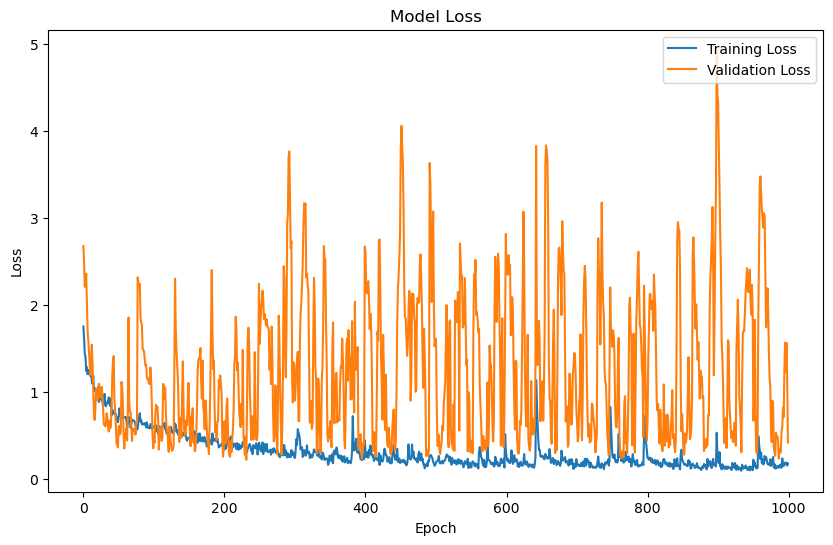

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7857 - loss: 0.8503 
Test accuracy: 0.8214285969734192
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
              precision    recall  f1-score   support

          OE       0.70      1.00      0.83        31
          RE       1.00      0.58      0.74        36
     Trachea       0.89      1.00      0.94        17

    accuracy                           0.82        84
   macro avg       0.87      0.86      0.84        84
weighted avg       0.87      0.82      0.81        84



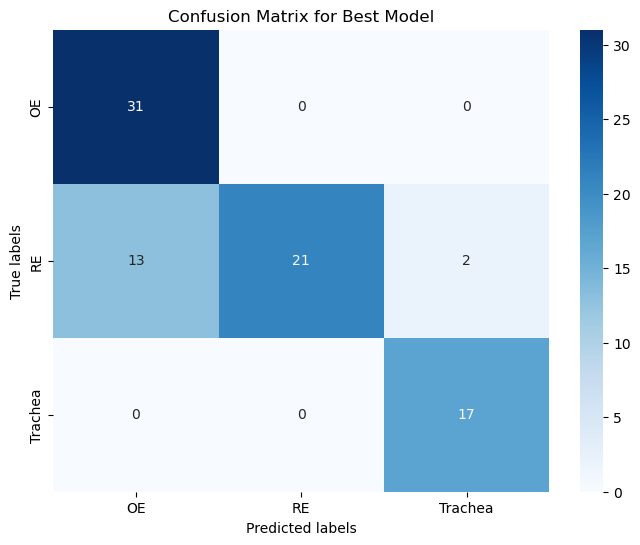

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set the best hyperparameters
best_hyperparameters = {
    'input_neurons': 30,
    'l1_reg': 3.026813046853553e-05,
    'hidden_neurons_0': 70,
    'l2_reg': 6.266052890779786e-05,
    'dropout_rate': 0.45,
    'hidden_neurons_1': 100,
    'hidden_neurons_2': 100,
    'hidden_neurons_3': 80,
    'hidden_neurons_4': 70,
    'learning_rate': 0.000301253516865534
}

# Build the model using the best hyperparameters
def build_fixed_model():
    model = Sequential()
    model.add(Dense(
        units=best_hyperparameters['input_neurons'],
        input_shape=(X_train.shape[1],),
        kernel_initializer=RandomNormal(mean=0.0, stddev=1/np.sqrt(X_train.shape[1])),
        activation='selu',
        kernel_regularizer=tf.keras.regularizers.l1(best_hyperparameters['l1_reg'])
    ))
    model.add(BatchNormalization())

    for i in range(5):  # Fixed number of hidden layers to 5
        model.add(Dense(
            units=best_hyperparameters[f'hidden_neurons_{i}'],
            kernel_initializer=RandomNormal(mean=0.0, stddev=1/np.sqrt(best_hyperparameters[f'hidden_neurons_{i}'])),
            activation='selu',
            kernel_regularizer=tf.keras.regularizers.l2(best_hyperparameters['l2_reg'])
        ))
        model.add(BatchNormalization())
        model.add(Dropout(rate=best_hyperparameters['dropout_rate']))

    model.add(Dense(3, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=best_hyperparameters['learning_rate']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Build and train the model
fixed_model = build_fixed_model()
history = fixed_model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), verbose=1)

# Save the model
fixed_model.save('best_model.h5')

# Save the loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Evaluate the best model on the test set
test_loss, test_accuracy = fixed_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

# Predict and evaluate the model performance
y_pred = np.argmax(fixed_model.predict(X_test), axis=-1)
print(classification_report(y_test, y_pred, target_names=['OE', 'RE', 'Trachea']))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['OE', 'RE', 'Trachea'], yticklabels=['OE', 'RE', 'Trachea'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Best Model')
plt.show()


Epoch 1/1000


/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.3700 - loss: 2.2534 - val_accuracy: 0.4096 - val_loss: 1.4468 - learning_rate: 3.0125e-05
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3740 - loss: 1.8917 - val_accuracy: 0.4096 - val_loss: 1.4323 - learning_rate: 3.0125e-05
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3893 - loss: 2.0674 - val_accuracy: 0.4096 - val_loss: 1.4256 - learning_rate: 3.0125e-05
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4078 - loss: 2.1205 - val_accuracy: 0.4096 - val_loss: 1.4282 - learning_rate: 3.0125e-05
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3805 - loss: 2.2384 - val_accuracy: 0.4096 - val_loss: 1.4190 - learning_rate: 3.0125e-05
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3360 - loss: 2.1879 - val_accuracy: 0.4096 - val_loss: 1.3921 - learning_rate: 3.0125e-05
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3995 - loss: 2.1530 - va

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4492 - loss: 1.7711 - val_accuracy: 0.5904 - val_loss: 0.9720 - learning_rate: 3.0125e-05
Epoch 45/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4778 - loss: 1.8525 - val_accuracy: 0.5542 - val_loss: 0.9743 - learning_rate: 3.0125e-05
Epoch 46/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5110 - loss: 1.6464 - val_accuracy: 0.5663 - val_loss: 0.9769 - learning_rate: 3.0125e-05
Epoch 47/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4331 - loss: 1.8490 - val_accuracy: 0.5783 - val_loss: 0.9696 - learning_rate: 1.0000e-05
Epoch 48/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4553 - loss: 1.7820 - val_accuracy: 0.5783 - val_loss: 0.9598 - learning_rate: 1.0000e-05
Epoch 49/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4406 - loss: 1.8806 - val_accuracy: 0.6024 - val_loss: 0.9466 - learning_rate: 1.0000e-05
Epoch 50/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4723 - loss: 1.8572

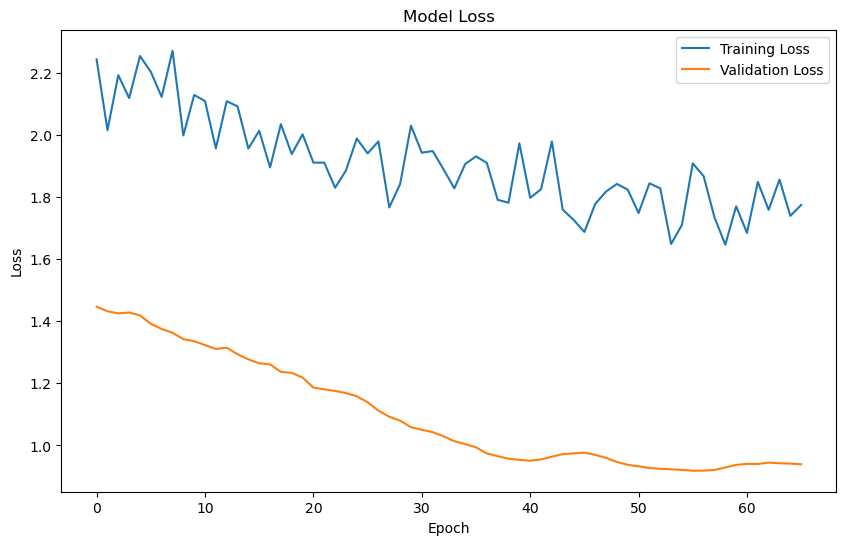

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5532 - loss: 0.9917 
Test accuracy: 0.5595238208770752
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
              precision    recall  f1-score   support

          OE       0.45      0.74      0.56        31
          RE       0.53      0.22      0.31        36
     Trachea       0.89      0.94      0.91        17

    accuracy                           0.56        84
   macro avg       0.62      0.64      0.60        84
weighted avg       0.57      0.56      0.53        84



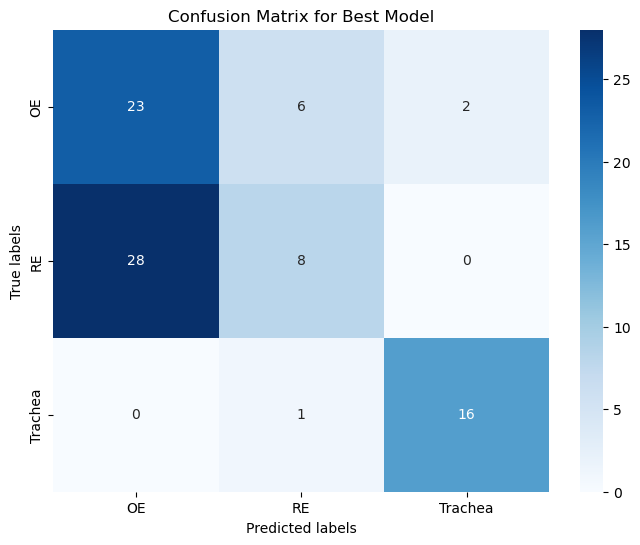

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set the best hyperparameters
best_hyperparameters = {
    'input_neurons': 30,
    'l1_reg': 3.026813046853553e-05,
    'hidden_neurons_0': 70,
    'l2_reg': 6.266052890779786e-04,  # Increased L2 regularization
    'dropout_rate': 0.45,
    'hidden_neurons_1': 100,
    'hidden_neurons_2': 100,
    'hidden_neurons_3': 80,
    'hidden_neurons_4': 70,
    'learning_rate': 0.000301253516865534 * 0.1  # Reduced learning rate
}

# Build the model using the best hyperparameters
def build_fixed_model():
    model = Sequential()
    model.add(Dense(
        units=best_hyperparameters['input_neurons'],
        input_shape=(X_train.shape[1],),
        kernel_initializer=RandomNormal(mean=0.0, stddev=1/np.sqrt(X_train.shape[1])),
        activation='selu',
        kernel_regularizer=tf.keras.regularizers.l1(best_hyperparameters['l1_reg'])
    ))
    model.add(BatchNormalization())

    for i in range(5):  # Fixed number of hidden layers to 5
        model.add(Dense(
            units=best_hyperparameters[f'hidden_neurons_{i}'],
            kernel_initializer=RandomNormal(mean=0.0, stddev=1/np.sqrt(best_hyperparameters[f'hidden_neurons_{i}'])),
            activation='selu',
            kernel_regularizer=tf.keras.regularizers.l2(best_hyperparameters['l2_reg'])
        ))
        model.add(BatchNormalization())
        model.add(Dropout(rate=best_hyperparameters['dropout_rate']))

    model.add(Dense(3, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=best_hyperparameters['learning_rate']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Build and train the model
fixed_model = build_fixed_model()

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = fixed_model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), batch_size=64, callbacks=[early_stopping, reduce_lr], verbose=1)

# Save the model
fixed_model.save('best_model.h5')

# Save the loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Evaluate the best model on the test set
test_loss, test_accuracy = fixed_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

# Predict and evaluate the model performance
y_pred = np.argmax(fixed_model.predict(X_test), axis=-1)
print(classification_report(y_test, y_pred, target_names=['OE', 'RE', 'Trachea']))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['OE', 'RE', 'Trachea'], yticklabels=['OE', 'RE', 'Trachea'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Best Model')
plt.show()

/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.3081 - loss: 2.5849 - val_accuracy: 0.2771 - val_loss: 4.0025 - learning_rate: 3.0125e-05
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3265 - loss: 2.4380 - val_accuracy: 0.2771 - val_loss: 3.7670 - learning_rate: 3.0125e-05
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3089 - loss: 2.5806 - val_accuracy: 0.2771 - val_loss: 3.6664 - learning_rate: 3.0125e-05
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2977 - loss: 2.5521 - val_accuracy: 0.2771 - val_loss: 3.5711 - learning_rate: 3.0125e-05
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3151 - loss: 2.5665 - val_accuracy: 0.2771 - val_loss: 3.5053 - learning_rate: 3.0125e-05
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3314 - loss: 2.6604 - val_accuracy: 0.2771 - val_loss: 3.4438 - learning_rate: 3.0125e-05
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3086 - loss:

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3392 - loss: 2.5559 - val_accuracy: 0.2771 - val_loss: 2.1478 - learning_rate: 3.0125e-05
Epoch 45/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3112 - loss: 2.5078 - val_accuracy: 0.2771 - val_loss: 2.1164 - learning_rate: 3.0125e-05
Epoch 46/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3291 - loss: 2.5163 - val_accuracy: 0.2771 - val_loss: 2.0969 - learning_rate: 3.0125e-05
Epoch 47/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3553 - loss: 2.3405 - val_accuracy: 0.2771 - val_loss: 2.0673 - learning_rate: 3.0125e-05
Epoch 48/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3613 - loss: 2.3066 - val_accuracy: 0.2771 - val_loss: 2.0461 - learning_rate: 3.0125e-05
Epoch 49/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3488 - loss: 2.3905 - val_accuracy: 0.2771 - val_loss: 2.0272 - learning_rate: 3.0125e-05
Epoch 50/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3567 - loss: 2.353

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3262 - loss: 2.4315 - val_accuracy: 0.3494 - val_loss: 1.7166 - learning_rate: 6.0251e-06
Epoch 88/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3397 - loss: 2.4884 - val_accuracy: 0.3494 - val_loss: 1.7175 - learning_rate: 6.0251e-06
Epoch 89/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3564 - loss: 2.3258 - val_accuracy: 0.3494 - val_loss: 1.7227 - learning_rate: 6.0251e-06
Epoch 90/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3699 - loss: 2.2120 - val_accuracy: 0.3494 - val_loss: 1.7181 - learning_rate: 6.0251e-06
Epoch 91/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3560 - loss: 2.3483 - val_accuracy: 0.3614 - val_loss: 1.7097 - learning_rate: 6.0251e-06
Epoch 92/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3678 - loss: 2.3718 - val_accuracy: 0.3855 - val_loss: 1.6948 - learning_rate: 6.0251e-06
Epoch 93/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3789 - loss: 2.313

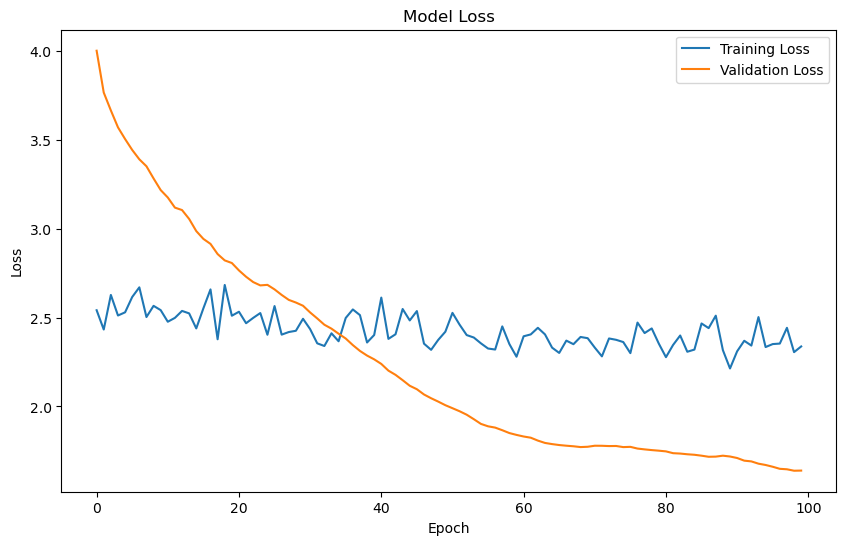

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3190 - loss: 1.8572 
Test accuracy: 0.3333333432674408
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
              precision    recall  f1-score   support

          OE       0.43      0.39      0.41        31
          RE       0.00      0.00      0.00        36
     Trachea       0.30      0.94      0.46        17

    accuracy                           0.33        84
   macro avg       0.24      0.44      0.29        84
weighted avg       0.22      0.33      0.24        84



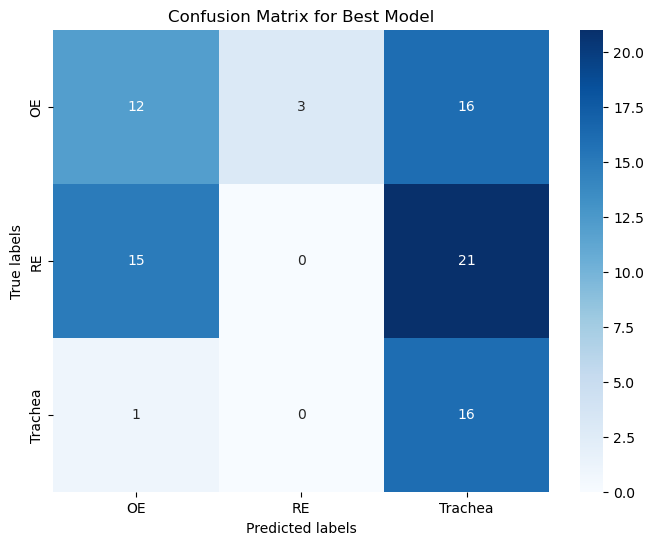

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set the best hyperparameters
best_hyperparameters = {
    'input_neurons': 30,
    'l1_reg': 3.026813046853553e-05,
    'hidden_neurons_0': 70,
    'l2_reg': 6.266052890779786e-04,  # Increased L2 regularization
    'dropout_rate': 0.45,
    'hidden_neurons_1': 100,
    'hidden_neurons_2': 100,
    'hidden_neurons_3': 80,
    'hidden_neurons_4': 70,
    'learning_rate': 0.0000301253516865534  # Reduced learning rate
}

# Build the model using the best hyperparameters
def build_fixed_model():
    model = Sequential()
    model.add(Dense(
        units=best_hyperparameters['input_neurons'],
        input_shape=(X_train.shape[1],),
        kernel_initializer=HeNormal(),
        activation='selu',
        kernel_regularizer=tf.keras.regularizers.l1(best_hyperparameters['l1_reg'])
    ))
    model.add(BatchNormalization())

    for i in range(5):  # Fixed number of hidden layers to 5
        model.add(Dense(
            units=best_hyperparameters[f'hidden_neurons_{i}'],
            kernel_initializer=HeNormal(),
            activation='selu',
            kernel_regularizer=tf.keras.regularizers.l2(best_hyperparameters['l2_reg'])
        ))
        model.add(BatchNormalization())
        model.add(Dropout(rate=best_hyperparameters['dropout_rate']))

    model.add(Dense(3, activation='softmax'))
    optimizer = Adam(learning_rate=best_hyperparameters['learning_rate'], clipvalue=1.0)  # Added gradient clipping
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Build and train the model
fixed_model = build_fixed_model()

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)

# Train the model
history = fixed_model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=128, callbacks=[early_stopping, reduce_lr], verbose=1)

# Save the model
fixed_model.save('best_model.h5')

# Save the loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Evaluate the best model on the test set
test_loss, test_accuracy = fixed_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

# Predict and evaluate the model performance
y_pred = np.argmax(fixed_model.predict(X_test), axis=-1)
print(classification_report(y_test, y_pred, target_names=['OE', 'RE', 'Trachea']))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['OE', 'RE', 'Trachea'], yticklabels=['OE', 'RE', 'Trachea'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Best Model')
plt.show()

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define learning rate schedule
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Set the best hyperparameters
best_hyperparameters = {
    'input_neurons': 30,
    'l1_reg': 3.026813046853553e-05,
    'hidden_neurons_0': 70,
    'l2_reg': 6.266052890779786e-05,
    'dropout_rate': 0.45,
    'hidden_neurons_1': 100,
    'hidden_neurons_2': 100,
    'hidden_neurons_3': 80,
    'hidden_neurons_4': 70,
    'learning_rate': 0.001  # Slightly increased initial learning rate
}

# Build the model using the best hyperparameters
def build_fixed_model():
    model = Sequential()
    model.add(Dense(
        units=best_hyperparameters['input_neurons'],
        input_shape=(X_train.shape[1],),
        kernel_initializer=HeNormal(),
        activation='selu',
        kernel_regularizer=tf.keras.regularizers.l1(best_hyperparameters['l1_reg'])
    ))
    model.add(BatchNormalization())

    for i in range(5):  # Fixed number of hidden layers to 5
        model.add(Dense(
            units=best_hyperparameters[f'hidden_neurons_{i}'],
            kernel_initializer=HeNormal(),
            activation='selu',
            kernel_regularizer=tf.keras.regularizers.l2(best_hyperparameters['l2_reg'])
        ))
        model.add(BatchNormalization())
        model.add(Dropout(rate=best_hyperparameters['dropout_rate']))

    model.add(Dense(3, activation='softmax'))
    optimizer = Adam(learning_rate=best_hyperparameters['learning_rate'])
    # optimizer = RMSprop(learning_rate=best_hyperparameters['learning_rate'])
    # optimizer = SGD(learning_rate=best_hyperparameters['learning_rate'], momentum=0.9)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Build and train the model
fixed_model = build_fixed_model()

# Early stopping, learning rate reduction, and learning rate schedule callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)
lr_scheduler = LearningRateScheduler(scheduler)

# Train the model
history = fixed_model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=128, callbacks=[early_stopping, reduce_lr, lr_scheduler], verbose=1)

# Save the model
fixed_model.save('best_model.h5')

# Save the loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Evaluate the best model on the test set
test_loss, test_accuracy = fixed_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

# Predict and evaluate the model performance
y_pred = np.argmax(fixed_model.predict(X_test), axis=-1)
print(classification_report(y_test, y_pred, target_names=['OE', 'RE', 'Trachea']))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['OE', 'RE', 'Trachea'], yticklabels=['OE', 'RE', 'Trachea'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Best Model')
plt.show()

Epoch 1/100


/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.3561 - loss: 1.8913 - val_accuracy: 0.4096 - val_loss: 8.5528 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4236 - loss: 1.6544 - val_accuracy: 0.4096 - val_loss: 8.3236 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4116 - loss: 1.5971 - val_accuracy: 0.4096 - val_loss: 6.7447 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3737 - loss: 1.7698 - val_accuracy: 0.4096 - val_loss: 4.6937 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4207 - loss: 1.6422 - val_accuracy: 0.4096 - val_loss: 3.4445 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3864 - loss: 1.6224 - val_accuracy: 0.4096 - val_loss: 3.0455 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4277 - loss: 1.5842 - val_accuracy: 0.4096 - val

ValueError: The output of the `schedule` function should be a float. Got: 0.0009048374486155808

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define learning rate schedule
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Set the best hyperparameters
best_hyperparameters = {
    'input_neurons': 30,
    'l1_reg': 3.026813046853553e-05,
    'hidden_neurons_0': 70,
    'l2_reg': 6.266052890779786e-05,
    'dropout_rate': 0.45,
    'hidden_neurons_1': 100,
    'hidden_neurons_2': 100,
    'hidden_neurons_3': 80,
    'hidden_neurons_4': 70,
    'learning_rate': 0.001  # Slightly increased initial learning rate
}

# Build the model using the best hyperparameters
def build_fixed_model():
    model = Sequential()
    model.add(Dense(
        units=best_hyperparameters['input_neurons'],
        input_shape=(X_train.shape[1],),
        kernel_initializer=HeNormal(),
        activation='selu',
        kernel_regularizer=tf.keras.regularizers.l1(best_hyperparameters['l1_reg'])
    ))
    model.add(BatchNormalization())

    for i in range(5):  # Fixed number of hidden layers to 5
        model.add(Dense(
            units=best_hyperparameters[f'hidden_neurons_{i}'],
            kernel_initializer=HeNormal(),
            activation='selu',
            kernel_regularizer=tf.keras.regularizers.l2(best_hyperparameters['l2_reg'])
        ))
        model.add(BatchNormalization())
        model.add(Dropout(rate=best_hyperparameters['dropout_rate']))

    model.add(Dense(3, activation='softmax'))
    optimizer = Adam(learning_rate=best_hyperparameters['learning_rate'])
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Load your data here (replace placeholders X_train, X_val, y_train, y_val, X_test, y_test with your actual data)
# Example:
# X_train, X_val, y_train, y_val, X_test, y_test = load_data()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)
lr_scheduler = LearningRateScheduler(scheduler)

# Build and train the model
fixed_model = build_fixed_model()
history = fixed_model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=128, callbacks=[early_stopping, reduce_lr, lr_scheduler], verbose=1)

# Save the model
fixed_model.save('best_model.h5')

# Save the loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Evaluate the best model on the test set
test_loss, test_accuracy = fixed_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

# Predict and evaluate the model performance
y_pred = np.argmax(fixed_model.predict(X_test), axis=-1)
print(classification_report(y_test, y_pred, target_names=['OE', 'RE', 'Trachea']))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['OE', 'RE', 'Trachea'], yticklabels=['OE', 'RE', 'Trachea'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Best Model')
plt.show()


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.3262 - loss: 1.9802 - val_accuracy: 0.3133 - val_loss: 9.4878 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4183 - loss: 1.8475 - val_accuracy: 0.3133 - val_loss: 6.9598 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3944 - loss: 1.7688 - val_accuracy: 0.3133 - val_loss: 5.4274 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4474 - loss: 1.7271 - val_accuracy: 0.3133 - val_loss: 4.8714 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4155 - loss: 1.5994 - val_accuracy: 0.3133 - val_loss: 4.0985 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4367 - loss: 1.5689 - val_accuracy: 0.3133 - val_loss: 3.6819 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4694 - loss: 1.5544 - val_accuracy: 0.

ValueError: The output of the `schedule` function should be a float. Got: 0.0009048374486155808